<a href="https://colab.research.google.com/github/Michaela131/Z4088/blob/master/Final_project_pokemoni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importy

In [ ]:
import numpy as np
import json
import requests
import kagglehub
import os
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
import keras
from keras.src.applications.densenet import DenseNet121, preprocess_input
from keras.src.models import Sequential
from keras.src.utils import image_dataset_from_directory
from keras import layers, models
from keras.src.layers import Dense, Dropout

import matplotlib.pyplot as plt
import pandas as pd



from PIL import Image, ImageOps

from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing import image_dataset_from_directory
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.models import Model, Sequential

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model
from tensorflow.keras.layers import Rescaling

from collections import Counter

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
#data preprocessing
  #handling missing values
  #data scaling
  #categorical features encoding
  #preparation or extraction of the test collection - test/train
  #data augmentation

#model architecture
  #input layer
  #hidden layer
  #output layer
  #neurons
  #activation functions
  #connection between neurons
  #parametres

#Loss function
#optimizer
#iteratice learning process
#Hyper parameter tunning
#Final testing










### Dataset

Vybrali jsme dataset obsahující obrázky 151 Pokémonů. Každý pokémon má unikátní vizuální znaky, které umožní neuronové síti ho identifikovat.


Úkol modelu:

Klasifikace do 151 tříd - rozpoznat jméno Pokémona podle obrázku.

Augmentace - Použití technik jako otočení, zoom nebo převrácení během tréninku zlepší výkonnost modelu na neznámých obrázcích.

GreyScale, změna rozlišení

In [ ]:
path = kagglehub.dataset_download("rogerkoala/first-gen-pokemon")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/first-gen-pokemon


In [ ]:
os.listdir(path)

['pokemons_gen1.csv', 'dataset']

In [ ]:
data_dir = f"{path}{os.sep}dataset"

### Příprava dat

In [ ]:
train_dir = 'pokemon_data/dataset/train'
test_dir = 'pokemon_data/dataset/test'

In [ ]:

#priprava dat

img_size = (224, 224)  #resampling na  224x224
batch_size = 32   #velikost batche 32


#definice trenovacich dat
train_dataset = image_dataset_from_directory(
    data_dir + os.sep + "train",
    label_mode='categorical',  #priradi label podle kategorie/slozek v adresari
    shuffle=True,
    image_size=img_size, # fotka bude upravena na velikost definovanou promennou v  img_size vyse
    batch_size=32
)

#definice testovacich dat
test_dataset = image_dataset_from_directory(
    data_dir + os.sep + "test",
    label_mode='categorical',
    shuffle=False,
    image_size=img_size,
    batch_size=32
)

Found 2249 files belonging to 151 classes.
Found 840 files belonging to 151 classes.


In [ ]:
class_names = train_dataset.class_names #seznam tříd/názvů jednotlivých kategorií, odvozenych z názvů složek při načítání datasetu


### Vizualizace

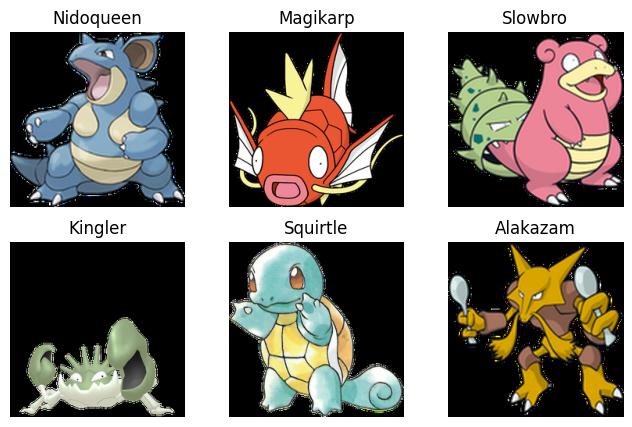

In [ ]:

plt.figure(figsize=(8, 5))
for images, labels in train_dataset.take(1):
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # One-hot -> index
        label_index = np.argmax(labels[i].numpy())
        plt.title(class_names[label_index])

        plt.axis("off")
plt.show()

### Gray Scale

In [ ]:
train_gs = image_dataset_from_directory(
    data_dir + os.sep + "train",
    image_size=(128, 128),  # Resize images
    batch_size=32,
    color_mode="grayscale",
    label_mode="categorical",
    shuffle=True
)

test_gs = image_dataset_from_directory(
    data_dir + os.sep + "test",
    image_size=(128, 128),
    batch_size=32,
    color_mode="grayscale",
    label_mode="categorical",
    shuffle=False
)

Found 2249 files belonging to 151 classes.
Found 840 files belonging to 151 classes.


In [ ]:
class_names = train_gs.class_names

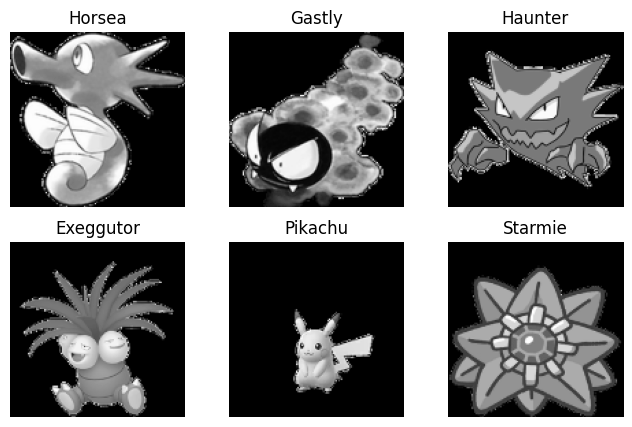

In [ ]:
plt.figure(figsize=(8, 5))
for images, labels in train_gs.take(1):  # Take 1 batch
    for i in range(6):  # Show first 6 images
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis("off")
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # např. 20 % validace
)

In [ ]:
train_generator = datagen.flow_from_directory(
    data_dir + os.sep + "train",
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',   # nebo 'categorical' pokud používáš one-hot
    subset='training',
    color_mode="grayscale"
)

val_generator = datagen.flow_from_directory(
    data_dir + os.sep + "test",
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    color_mode="grayscale",
    shuffle=False
)

Found 1867 images belonging to 151 classes.
Found 152 images belonging to 151 classes.


In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

### Augmentace

In [ ]:
"""
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])
"""

'\ndata_augmentation = Sequential([\n    RandomFlip("horizontal"),\n    RandomRotation(0.1),\n    RandomZoom(0.1),\n])\n'

### Base model

In [ ]:
model = Sequential([
    Rescaling(1./255, input_shape=(128, 128, 1)),

    Conv2D(32, (3, 3), activation='relu'), #conv2D-najde základní rysy(hrany, textury), 32 filtrů o velikosti 3x3
    MaxPooling2D(2, 2), #zmenší velikost obrázku na polovinu - snížení dimenze
    BatchNormalization(), #stabilizuje učení, zrychluje trénink

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    GlobalAveragePooling2D(), # z 3D výstupu z poslední konvoluce udělá 1D vektor, průměruje prostorové informace - méně parametrů než Flatten, funguje dobře u malých obrázků i mnoha tříd
    Dropout(0.4), #náhodně vypne 40 % neuronů - pomáhá proti přeučení

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(151, activation='softmax')  # 151 tříd
])

early_stop = EarlyStopping(patience=10, restore_best_weights=True)#nezlepší se po N epochách, zastaví trénování
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5) #pokud se monitorovaná metrika nezlepší po N epochách, sníží learning_rate
#sleduje metriky a když se nezlepšuje, automaticky sníží learning_rate, aby model mohl dokonaleji ladit své váhy

loss = CategoricalCrossentropy(label_smoothing = 0.1)

model.compile(optimizer="adam",
              loss=loss,
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 151)                 │          19,479 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129,559 (506.09 KB)

 Trainable params: 129,111 (504.34 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model.fit(train_gs,
                    validation_data=test_gs,
                    epochs=100)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.0089 - loss: 5.0444 - val_accuracy: 0.0107 - val_loss: 5.0682
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0464 - loss: 4.7992 - val_accuracy: 0.0095 - val_loss: 5.9527
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0545 - loss: 4.6150 - val_accuracy: 0.0131 - val_loss: 7.5914
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0767 - loss: 4.4760 - val_accuracy: 0.0179 - val_loss: 8.0713
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0763 - loss: 4.3687 - val_accuracy: 0.0119 - val_loss: 8.0550
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0917 - loss: 4.2824 - val_accuracy: 0.0071 - val_loss: 8.0035
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.1005 - loss: 4.1607 - val_accuracy: 0.0167 - val_loss: 7.3095
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.1189 - loss: 4.0606 - val_accuracy: 0

In [ ]:
# Získání predikcí (pravděpodobností)
pred_probs = model.predict(test_gs)

# Převod na třídy (argmax z pravděpodobností)
y_pred = np.argmax(pred_probs, axis=1)

# Získání skutečných labelů (one-hot → indexy)
y_true = np.concatenate([np.argmax(label.numpy(), axis=1) for _, label in test_gs])

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [ ]:
class_names = test_gs.class_names

### 10 nejčastějších záměn

In [ ]:
# Vytvoření seznamu dvojic (skutečný, predikovaný), jen když jsou různé
confusions = list(zip(y_true, y_pred))
common_confusions = Counter([pair for pair in confusions if pair[0] != pair[1]])

# Vezmi top 10 nejčastějších záměn
top_confused = common_confusions.most_common(10)

# Správné rozbalení dvojic (pair, count)
for (true_idx, pred_idx), count in top_confused:
    print(f"Skutečné: {class_names[true_idx]} -> Predikované: {class_names[pred_idx]} ({count}x)")

Skutečné: Pikachu -> Predikované: Jigglypuff (5x)
Skutečné: Kangaskhan -> Predikované: Slowbro (3x)
Skutečné: Nidorino -> Predikované: Nidoran-m (3x)
Skutečné: Alakazam -> Predikované: Mewtwo (2x)
Skutečné: Bellsprout -> Predikované: Victreebel (2x)
Skutečné: Chansey -> Predikované: Jigglypuff (2x)
Skutečné: Charmander -> Predikované: Dratini (2x)
Skutečné: Clefairy -> Predikované: Jigglypuff (2x)
Skutečné: Cubone -> Predikované: Jigglypuff (2x)
Skutečné: Dodrio -> Predikované: Doduo (2x)


### Confusion Matrix

In [ ]:
# Vypočítání matice záměn
cm = confusion_matrix(y_true, y_pred)

In [ ]:
# předpoklad: máš y_true, y_pred (jako čísla tříd)
confusions = list(zip(y_true, y_pred))
common_confusions = Counter([pair for pair in confusions if pair[0] != pair[1]])

# Top 10 nejčastějších záměn (pair, count)
top_confused = common_confusions.most_common(10)

# Získáme jen unikátní třídy z těchto záměn
confused_classes = sorted(set([i for pair, _ in top_confused for i in pair]))

In [ ]:
# Mapa z původních indexů na nové indexy (0..N)
new_idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(confused_classes)}

# Filtrování y_true / y_pred jen na relevantní případy
filtered_true = []
filtered_pred = []

for yt, yp in zip(y_true, y_pred):
    if yt in confused_classes and yp in confused_classes:
        filtered_true.append(new_idx_map[yt])
        filtered_pred.append(new_idx_map[yp])

# Seznam názvů tříd v novém pořadí
confused_class_names = [class_names[i] for i in confused_classes]

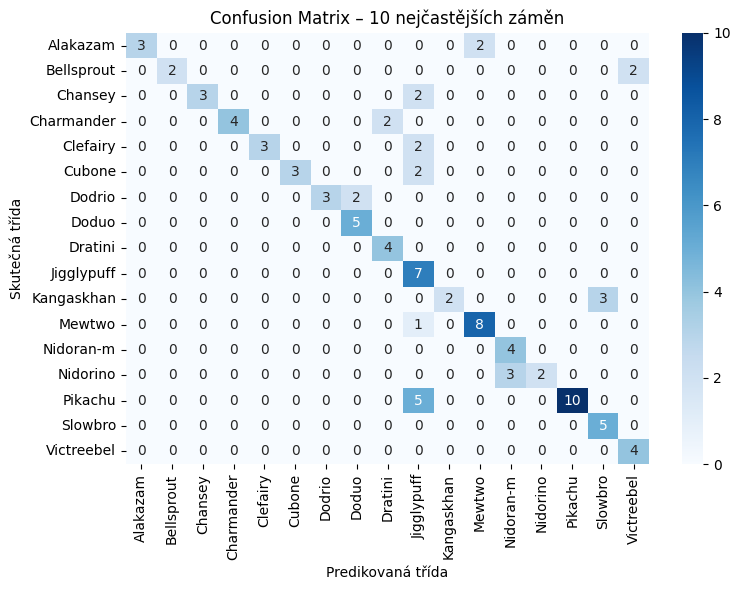

In [ ]:
cm = confusion_matrix(filtered_true, filtered_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=confused_class_names,
            yticklabels=confused_class_names)
plt.xlabel('Predikovaná třída')
plt.ylabel('Skutečná třída')
plt.title('Confusion Matrix – 10 nejčastějších záměn')
plt.tight_layout()
plt.show()

### Clasification report

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        Abra       1.00      0.80      0.89         5
  Aerodactyl       1.00      0.80      0.89         5
    Alakazam       0.75      0.60      0.67         5
       Arbok       1.00      0.80      0.89         5
    Arcanine       0.83      1.00      0.91         5
    Articuno       0.83      1.00      0.91         5
    Beedrill       1.00      0.80      0.89         5
  Bellsprout       1.00      0.50      0.67         4
   Blastoise       0.38      0.71      0.50         7
   Bulbasaur       0.64      0.88      0.74         8
  Butterfree       0.50      0.83      0.62         6
    Caterpie       0.50      0.40      0.44         5
     Chansey       1.00      0.50      0.67         6
   Charizard       0.71      0.62      0.67         8
  Charmander       0.57      0.50      0.53         8
  Charmeleon       0.40      0.40      0.40         5
    Clefable       1.00      0.60      0.75         5
    Clefairy       0.60    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save("model.keras")

In [ ]:
from IPython.display import FileLink
FileLink("model.keras")

/kaggle/working/model.keras